# Section 1: Importing our Modules, Packages, API Base, and API Key
### This section loads the main modules we used for the project and suppresses specific warnings. 

In [31]:
import os #module that creates, opens, and closes files.
import litellm #litellm server
import json 
import warnings
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
import requests
import networkx as nx 
from tqdm import tqdm
import time 

# Load environment variables
load_dotenv()

# Suppress specific Pydantic warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")

custom_api_base = "https://litellmproxy.osu-ai.org" #Class 9 Section 1, key we use for API 
astro1221_key = os.getenv("ASTRO1221_API_KEY") 


# Section 2: Reading and Opening our File 

In [32]:
filename = "p_paper_abstract.txt"

with open(filename, 'r') as f:  # 'r' means read mode
  lines = f.readlines()
    
print(f"Read {len(lines)} lines from file")

FileNotFoundError: [Errno 2] No such file or directory: 'p_paper_abstract.txt'

# Section 3: Conversation Prompt and Character Descriptions 
### This section includes the prompt we use to generate the conversation amongst our three characters, along with their personality traits and the flow of the discussion. 

In [33]:
conversation_prompt = """ 
CHARACTERS:
-Dr. Daniel Beer: an enthusiastic and inquisitive astrophysicist that studies cosmology, including dark matter
and dark energy, galactic evolution and quasars, and the intergalactic medium (IGM).

-Dr. Davis Milk: a curious and passionate astrophysicist that studies supermassive black holes.

-Dr. Phil Marg: an excited and speculative astrophyscist that studies
cosmology, specifically galactic evolution and active galactic nuclei (AGN).

DISCUSSION:
Have the characters have a debate about the paper THE ORIGIN OF DUST IN EARLY-TYPE GALAXIES 
AND IMPLICATIONS FOR ACCRETION ONTO SUPERMASSIVE BLACK HOLES 
Paul Martini 1,4,  Daniel Dicken 2, and Thaisa Storchi-Bergmann. 

CONVERSATION FLOW: 
Have the characters talk in random order amongst each other as if they are humans having an ordinary debate. 
They do not have to talk in the order in which the characters are listed 
- For example, the order can be: "Dr. Phil Marg" to "Dr. Davis Milk" to "Dr. Phil Marg" to "Dr. Daniel Milk". 
Make the conversation natural. 
."""

#Class 9: Section 4 



# Section 4: LLM Prompt Function
### This section includes the specifics of our function used to call the LLM.

In [34]:
def prompt_llm(messages, model="openai/GPT-4.1-mini", temperature=0.5, max_tokens=1000, tools=None, verbose=True): #Class 9 Section 1 
    """   
    Send a prompt or conversation to an LLM using LiteLLM and return the response.
    """ #The prompt_llm() defines function for creating an LLM prompt. 
    if isinstance(messages, str):
        messages = [{"role": "user", "content": conversation_prompt}] 
        #The messages variable creates dictionary for LLM response (role is user, content is the generated 
        #message from the conversation prompt (ONLY IF STRING).
       
    if not (isinstance(temperature, (int, float)) and 0 <= temperature <= 2): 
        raise ValueError("temperature must be a float between 0 and 2 (inclusive).") 
        #rasies error if temperature is less than 0 or greater than 2, as temperature must be within (0,2).
    if not (isinstance(max_tokens, int) and max_tokens > 0):
        raise ValueError("max_tokens must be a positive integer.")
        #raises error if max_tokens amount is less than zero.
   

    try: 
        print("Contacting LLM via University Server...")
        conversation_response = litellm.completion(
            model=model,
            messages=messages,
            tools=tools,
            api_base=custom_api_base,
            api_key=astro1221_key,
            temperature=temperature,
            max_tokens=max_tokens, 
        ) #The try block contacts the LLM server through litellm.completion function to get response 
          #using the model, message (our prompt), api base and key, 
          #and the temperature and tokens we established above.
      
        
        conversation_answer = conversation_response['choices'][0]['message']['content'] 
        if verbose: 
            print(f"\nSUCCESS! Here is the discussion from {model}:\n")
            print(conversation_answer + "\n")
            print(f"{conversation_answer['name']}: {conversation_answer['reply']}")
            conversation_history += f"{conversation_answer['name']}: {conversation_answer['reply']}\n"
         #The conversation_answer represents the AI's answer from the conversation_response function 
         #and if there's enough info generated from the conversation response (verbose), it prints the conversation 
         #in the format of (name): reply
    
    except Exception as e:
        print(f"\nERROR: Could not connect. Details:\n{e}")    
        conversation_response = None 
        #if it doesn't work, print 
    
    return conversation_response 

 

# Section 5: LLM Memory Function
### This section includes our function that saves the LLM's discussion output.

In [35]:
def conversation_with_history(user_input):
    conversation_history = [{"role": "user", "content": conversation_prompt}] 
    #This saves content from the conversation prompt response into conversation_history variable. 
    conversation_history.append({"role": "user", "content": user_input})
    response = prompt_llm(conversation_history) 
    if response is None:
        return None
    ai_answer = response.choices[0].message.content

    conversation_history.append({"role": "system", "content": ai_answer})
    # conversation_history.append adds the AI's own answer to memory so it remembers what it said

    return ai_answer
#Class 9 Section 5

# Section 6: Discussion Output and Tracking Interactions 
### In this section, we generate the conversation amongst the three characters and use a seperate prompt to keep track of how many times the different characters directly interact with one another. 

In [37]:
prompt_llm(conversation_prompt)
print('=' * 60) #Spacing for organization

conversation_summary_prompt = "Make an organized list to show which characters interacted with each other and how many times they did."

print(f"\nAsking about question original conversation: {conversation_summary_prompt}")
print(conversation_with_history(conversation_summary_prompt)) 
# AI/LLM remembers what three characters talked about. 

#Class 9 Section 5

Contacting LLM via University Server...

SUCCESS! Here is the discussion from openai/GPT-4.1-mini:

Dr. Davis Milk: Have you both had a chance to dig into Martini et al.'s paper on dust origins in early-type galaxies? I found their argument about internal versus external dust production quite compelling, especially how it ties into feeding supermassive black holes.

Dr. Phil Marg: Absolutely, Davis! What really struck me was their suggestion that most of the dust in these galaxies likely comes from external accretion rather than internal stellar sources. It challenges the traditional view that evolved stars are the primary dust contributors in early-type systems.

Dr. Daniel Beer: I agree that the external accretion scenario is persuasive, but I wonder about the implications for the intergalactic medium. If early-type galaxies are acquiring dust externally, does that mean the IGM is dust-rich enough to supply this material? That could have broader consequences for our understanding of 

# Section 7: Creating our CSV to Track Interactions

In [38]:
import csv

response_data = [
      {'Link': 'Dr. Daniel Beer - Dr. Davis Milk', 'Interaction Count': 2},
      {'Link': 'Dr. Davis Milk - Dr. Phil Marg',   'Interaction Count': 3},
      {'Link': 'Dr. Phil Marg - Dr. Daniel Beer',  'Interaction Count': 2}
]
with open('response_data.csv', 'w', newline='') as file:
    fieldnames = ['Link', 'Interaction Count']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    #fieldnames defines our headers, Link and Interaction Count
    writer.writeheader()
    writer.writerows(response_data)
    
print("Created response_data.csv") 
# Write data rows
with open('response_data.csv', mode='r') as file:
    reader = csv.DictReader(file)
    print(f"{'Link'}                        |  {'Interaction Count'}")
    print("=" * 50)
    
    for row in reader:
        link = row['Link']
        interaction_count = float(row['Interaction Count'])
        
        print(f"{link} |        {interaction_count}")

Created response_data.csv
Link                        |  Interaction Count
Dr. Daniel Beer - Dr. Davis Milk |        2.0
Dr. Davis Milk - Dr. Phil Marg |        3.0
Dr. Phil Marg - Dr. Daniel Beer |        2.0


# Section 8: Using Pandas to Read our CSV and Create our Network Diagram

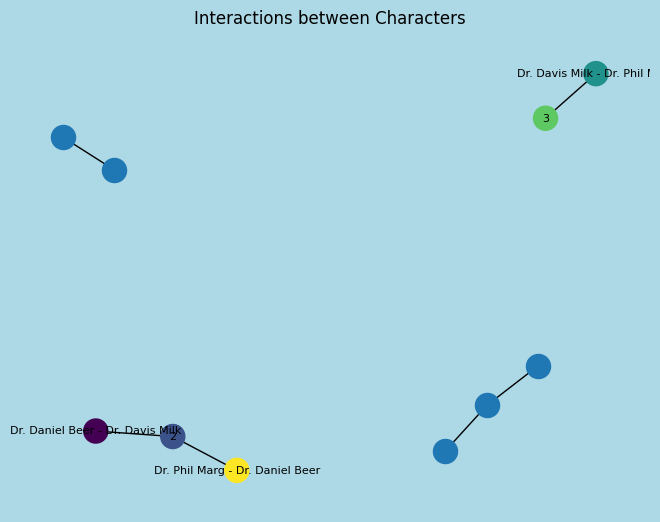

In [39]:
import pandas as pd

df = pd.read_csv("response_data.csv")
df
# Here, we used pandas to read our response data csv in the form of the variable "df"
G= nx.from_pandas_edgelist(df, "Link", "Interaction Count")
# Here, we used a networkx function to create a data frame with the keys "Link" and "Interaction Count" 
# using data straight from the csv 
val = []
for i in range(len(G.nodes)):
    val.append(i)
nx.set_node_attributes(G, val, 'val')
#gives individual color to each node (circle)
fig = plt.figure()
nx.draw(G)
nx.draw(G, with_labels=True, font_size=8, node_color=val) 
# This edits the  
fig.set_facecolor('lightblue')
plt.title('Interactions between Characters')
plt.show() 


#Used Lecture 11 and Graphing Network Data with Pandas (https://pandas.pythonhumanities.com/04_02_graphing_networks_with_pandas.html)